In [1]:
#basic only acrima
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/ACRIMA/ACRIMA/PARTITIONED/Training/"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/ACRIMA/ACRIMA/PARTITIONED/Testing/"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Lower batch size for memory efficiency
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hybrid Model with Self-Gating Mechanism
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features.parameters():
            param.requires_grad = True
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.gate = nn.Linear(feature_dim, feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        # Self-gating mechanism
        gate_values = torch.sigmoid(self.gate(fused_features))
        gated_features = fused_features * gate_values
        
        gated_features = self.batch_norm(gated_features)
        gated_features = self.dropout(gated_features)
        return self.fc(gated_features)

# Model initialization
model = HybridModel().to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

# Loss function
criterion = nn.CrossEntropyLoss()

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total * 100

# Training function
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        test_accuracy = evaluate_model(model, test_loader, device)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Acc: {test_accuracy:.2f}%")
        scheduler.step()
    
# Train the model
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel wer

Epoch [1/50] - Loss: 0.4884 - Train Acc: 76.06% - Test Acc: 91.49%
Epoch [2/50] - Loss: 0.3153 - Train Acc: 87.41% - Test Acc: 90.07%
Epoch [3/50] - Loss: 0.2406 - Train Acc: 89.72% - Test Acc: 94.33%
Epoch [4/50] - Loss: 0.1696 - Train Acc: 94.15% - Test Acc: 97.16%
Epoch [5/50] - Loss: 0.1930 - Train Acc: 93.79% - Test Acc: 96.45%
Epoch [6/50] - Loss: 0.1524 - Train Acc: 93.62% - Test Acc: 96.45%
Epoch [7/50] - Loss: 0.1236 - Train Acc: 95.21% - Test Acc: 97.16%
Epoch [8/50] - Loss: 0.1335 - Train Acc: 95.39% - Test Acc: 96.45%


KeyboardInterrupt: 

In [1]:

#only acrima again
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/ACRIMA/ACRIMA/PARTITIONED/Training/"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/ACRIMA/ACRIMA/PARTITIONED/Testing/"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Lower batch size for memory efficiency
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Synthetic Data Generator (GAN-based)
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(3, 224, 224)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, np.prod(img_shape)),
            nn.Tanh()
        )
        self.img_shape = img_shape
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

generator = Generator().to(device)

# Hybrid Model with Attention-based Feature Fusion
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features.parameters():
            param.requires_grad = True
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.attention_weights = nn.Linear(feature_dim, 1)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        # Feature Fusion using Attention-based Weighting
        attention_scores = torch.sigmoid(self.attention_weights(fused_features))
        weighted_features = fused_features * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

# Model initialization
model = HybridModel().to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=50)

# Loss function
criterion = nn.CrossEntropyLoss()

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total * 100

# Training function
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        test_accuracy = evaluate_model(model, test_loader, device)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Acc: {test_accuracy:.2f}%")
        scheduler.step()
    
# Train the model
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel wer

Epoch [1/50] - Loss: 0.3391 - Train Acc: 85.28% - Test Acc: 86.52%
Epoch [2/50] - Loss: 0.1682 - Train Acc: 93.26% - Test Acc: 95.04%
Epoch [3/50] - Loss: 0.1774 - Train Acc: 93.97% - Test Acc: 90.78%
Epoch [4/50] - Loss: 0.1263 - Train Acc: 94.68% - Test Acc: 92.20%
Epoch [5/50] - Loss: 0.1671 - Train Acc: 93.97% - Test Acc: 94.33%
Epoch [6/50] - Loss: 0.1188 - Train Acc: 95.39% - Test Acc: 97.16%
Epoch [7/50] - Loss: 0.1473 - Train Acc: 94.86% - Test Acc: 97.16%
Epoch [8/50] - Loss: 0.0564 - Train Acc: 98.05% - Test Acc: 95.04%


KeyboardInterrupt: 

In [2]:
#BASIC GAN ACRIMA_DRISHTI BEST AS OF NOW

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Lower batch size for memory efficiency
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Synthetic Data Generator (GAN-based)
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(3, 224, 224)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, np.prod(img_shape)),
            nn.Tanh()
        )
        self.img_shape = img_shape
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

generator = Generator().to(device)

# Hybrid Model with Attention-based Feature Fusion
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features.parameters():
            param.requires_grad = True
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.attention_weights = nn.Linear(feature_dim, 1)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        # Feature Fusion using Attention-based Weighting
        attention_scores = torch.sigmoid(self.attention_weights(fused_features))
        weighted_features = fused_features * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

# Model initialization
model = HybridModel().to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=50)

# Loss function
criterion = nn.CrossEntropyLoss()

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total * 100

# Training function
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        test_accuracy = evaluate_model(model, test_loader, device)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Acc: {test_accuracy:.2f}%")
        scheduler.step()
    
# Train the model
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/50] - Loss: 0.4288 - Train Acc: 81.60% - Test Acc: 85.94%
Epoch [2/50] - Loss: 0.1740 - Train Acc: 92.83% - Test Acc: 83.85%
Epoch [3/50] - Loss: 0.1764 - Train Acc: 92.83% - Test Acc: 89.58%
Epoch [4/50] - Loss: 0.1398 - Train Acc: 95.11% - Test Acc: 91.67%
Epoch [5/50] - Loss: 0.1522 - Train Acc: 93.97% - Test Acc: 93.23%
Epoch [6/50] - Loss: 0.1369 - Train Acc: 93.97% - Test Acc: 89.06%
Epoch [7/50] - Loss: 0.0921 - Train Acc: 96.42% - Test Acc: 90.62%
Epoch [8/50] - Loss: 0.1159 - Train Acc: 95.28% - Test Acc: 86.46%
Epoch [9/50] - Loss: 0.0933 - Train Acc: 96.58% - Test Acc: 86.98%
Epoch [10/50] - Loss: 0.0582 - Train Acc: 97.88% - Test Acc: 93.75%
Epoch [11/50] - Loss: 0.1184 - Train Acc: 96.58% - Test Acc: 91.15%
Epoch [12/50] - Loss: 0.1259 - Train Acc: 95.77% - Test Acc: 89.58%
Epoch [13/50] - Loss: 0.0728 - Train Acc: 97.56% - Test Acc: 91.67%
Epoch [14/50] - Loss: 0.0659 - Train Acc: 97.56% - Test Acc: 88.02%
Epoch [15/50] - Loss: 0.0853 - Train Acc: 97.23% - Test A

In [1]:



import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Lower batch size for memory efficiency
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Synthetic Data Generator (GAN-based)
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(3, 224, 224)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, np.prod(img_shape)),
            nn.Tanh()
        )
        self.img_shape = img_shape
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

generator = Generator().to(device)

# CycleGAN Placeholder for Domain Adaptation
class CycleGANGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

cycle_gan = CycleGANGenerator().to(device)

# Hybrid Model with Attention-based Feature Fusion
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features.parameters():
            param.requires_grad = True
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.attention_weights = nn.Linear(feature_dim, 1)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        # Feature Fusion using Attention-based Weighting
        attention_scores = torch.sigmoid(self.attention_weights(fused_features))
        weighted_features = fused_features * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

# Model initialization
model = HybridModel().to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=50)

# Loss function
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        
        # Testing Phase
        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                correct_test += (outputs.argmax(1) == labels).sum().item()
                total_test += labels.size(0)
        
        test_accuracy = correct_test / total_test * 100
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Acc: {test_accuracy:.2f}%")
        scheduler.step()
    
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)

/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel wer

Epoch [1/50] - Loss: 0.3905 - Train Acc: 81.11% - Test Acc: 81.25%
Epoch [2/50] - Loss: 0.2679 - Train Acc: 88.76% - Test Acc: 84.90%
Epoch [3/50] - Loss: 0.2128 - Train Acc: 91.21% - Test Acc: 85.94%
Epoch [4/50] - Loss: 0.1927 - Train Acc: 93.65% - Test Acc: 89.58%
Epoch [5/50] - Loss: 0.1288 - Train Acc: 94.79% - Test Acc: 89.58%
Epoch [6/50] - Loss: 0.1655 - Train Acc: 94.14% - Test Acc: 85.42%
Epoch [7/50] - Loss: 0.1346 - Train Acc: 93.97% - Test Acc: 90.10%
Epoch [8/50] - Loss: 0.1471 - Train Acc: 94.14% - Test Acc: 88.02%
Epoch [9/50] - Loss: 0.1252 - Train Acc: 95.44% - Test Acc: 91.15%
Epoch [10/50] - Loss: 0.1068 - Train Acc: 96.58% - Test Acc: 90.62%
Epoch [11/50] - Loss: 0.1246 - Train Acc: 95.11% - Test Acc: 84.90%
Epoch [12/50] - Loss: 0.1214 - Train Acc: 94.63% - Test Acc: 91.67%
Epoch [13/50] - Loss: 0.0639 - Train Acc: 97.23% - Test Acc: 90.10%
Epoch [14/50] - Loss: 0.0842 - Train Acc: 97.07% - Test Acc: 91.67%
Epoch [15/50] - Loss: 0.1270 - Train Acc: 95.77% - Test A

In [1]:
#self-supervised learning (SSL) module using SimCLR for fundus images
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Lower batch size for memory efficiency
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Self-Supervised Learning (SSL) using SimCLR
class SimCLR(nn.Module):
    def __init__(self, base_encoder, out_dim=128):
        super().__init__()
        self.encoder = base_encoder
        self.projection_head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
    
    def forward(self, x):
        features = self.encoder(x).last_hidden_state[:, 0, :]
        return self.projection_head(features)

vit_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224")
simclr = SimCLR(vit_encoder).to(device)

# CycleGAN Placeholder for Domain Adaptation
class CycleGANGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

cycle_gan = CycleGANGenerator().to(device)

# Hybrid Model with Attention-based Feature Fusion
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features.parameters():
            param.requires_grad = True
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.attention_weights = nn.Linear(feature_dim, 1)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        # Feature Fusion using Attention-based Weighting
        attention_scores = torch.sigmoid(self.attention_weights(fused_features))
        weighted_features = fused_features * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

# Model initialization
model = HybridModel().to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=50)

# Loss function
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        
        # Testing Phase
        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                correct_test += (outputs.argmax(1) == labels).sum().item()
                total_test += labels.size(0)
        
        test_accuracy = correct_test / total_test * 100
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Acc: {test_accuracy:.2f}%")
        scheduler.step()
    
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)

/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are d

Epoch [1/50] - Loss: 0.4052 - Train Acc: 83.22% - Test Acc: 70.31%
Epoch [2/50] - Loss: 0.2688 - Train Acc: 89.41% - Test Acc: 85.94%
Epoch [3/50] - Loss: 0.2119 - Train Acc: 91.69% - Test Acc: 81.25%
Epoch [4/50] - Loss: 0.1654 - Train Acc: 92.83% - Test Acc: 91.67%
Epoch [5/50] - Loss: 0.1041 - Train Acc: 95.44% - Test Acc: 82.81%
Epoch [6/50] - Loss: 0.1699 - Train Acc: 94.79% - Test Acc: 89.06%
Epoch [7/50] - Loss: 0.1309 - Train Acc: 95.77% - Test Acc: 89.06%
Epoch [8/50] - Loss: 0.1247 - Train Acc: 95.44% - Test Acc: 83.33%
Epoch [9/50] - Loss: 0.1019 - Train Acc: 95.93% - Test Acc: 88.54%
Epoch [10/50] - Loss: 0.1070 - Train Acc: 95.60% - Test Acc: 90.10%
Epoch [11/50] - Loss: 0.1191 - Train Acc: 97.07% - Test Acc: 90.10%
Epoch [12/50] - Loss: 0.0964 - Train Acc: 96.58% - Test Acc: 88.54%
Epoch [13/50] - Loss: 0.0815 - Train Acc: 97.39% - Test Acc: 88.02%
Epoch [14/50] - Loss: 0.0932 - Train Acc: 96.58% - Test Acc: 91.67%
Epoch [15/50] - Loss: 0.0542 - Train Acc: 98.37% - Test A

KeyboardInterrupt: 

In [2]:
#imporved MOST COMPLEX

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Self-Supervised Learning (SSL) using SimCLR
class SimCLR(nn.Module):
    def __init__(self, base_encoder, out_dim=128):
        super().__init__()
        self.encoder = base_encoder
        self.projection_head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
    
    def forward(self, x):
        features = self.encoder(x).last_hidden_state[:, 0, :]
        return self.projection_head(features)

vit_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224")
simclr = SimCLR(vit_encoder).to(device)

# CycleGAN Generator
class CycleGANGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

cycle_gan = CycleGANGenerator().to(device)

# Hybrid Model with Attention-based Feature Fusion
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.attention_weights = nn.Linear(feature_dim, 1)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        attention_scores = torch.sigmoid(self.attention_weights(fused_features))
        weighted_features = fused_features * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

# Training function
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        
        # Testing Phase
        model.eval()
        correct_test, total_test = 0, 0
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                correct_test += (outputs.argmax(1) == labels).sum().item()
                total_test += labels.size(0)
        
        test_accuracy = correct_test / total_test * 100
        avg_test_loss = running_test_loss / len(test_loader)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Loss: {avg_test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")
        scheduler.step()

# Initialize and train model
model = HybridModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=50)
criterion = nn.CrossEntropyLoss()
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weig

Epoch [1/50] - Loss: 0.4238 - Train Acc: 81.92% - Test Loss: 0.3009 - Test Acc: 88.54%
Epoch [2/50] - Loss: 0.2417 - Train Acc: 89.90% - Test Loss: 0.2769 - Test Acc: 89.58%
Epoch [3/50] - Loss: 0.2284 - Train Acc: 91.21% - Test Loss: 0.2473 - Test Acc: 91.67%
Epoch [4/50] - Loss: 0.2452 - Train Acc: 88.60% - Test Loss: 0.2812 - Test Acc: 87.50%
Epoch [5/50] - Loss: 0.1847 - Train Acc: 92.67% - Test Loss: 0.2573 - Test Acc: 91.15%
Epoch [6/50] - Loss: 0.1752 - Train Acc: 93.16% - Test Loss: 0.4435 - Test Acc: 80.73%
Epoch [7/50] - Loss: 0.1398 - Train Acc: 93.97% - Test Loss: 0.2598 - Test Acc: 91.67%
Epoch [8/50] - Loss: 0.1385 - Train Acc: 94.79% - Test Loss: 0.2559 - Test Acc: 89.06%
Epoch [9/50] - Loss: 0.1000 - Train Acc: 96.09% - Test Loss: 0.3342 - Test Acc: 84.90%
Epoch [10/50] - Loss: 0.1023 - Train Acc: 95.77% - Test Loss: 0.4553 - Test Acc: 85.42%
Epoch [11/50] - Loss: 0.1054 - Train Acc: 96.09% - Test Loss: 0.3717 - Test Acc: 85.42%
Epoch [12/50] - Loss: 0.1329 - Train Acc:

In [1]:
#all final improved STABLE 90S
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
    transforms.ToTensor(),  # Convert to tensor first
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),  # Apply RandomErasing after ToTensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hybrid Model with Attention-based Feature Fusion
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.attention_weights = nn.Linear(feature_dim, 1)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.6)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        attention_scores = torch.sigmoid(self.attention_weights(fused_features))
        weighted_features = fused_features * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

# Training function
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        
        # Testing Phase
        model.eval()
        correct_test, total_test = 0, 0
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                correct_test += (outputs.argmax(1) == labels).sum().item()
                total_test += labels.size(0)
        
        test_accuracy = correct_test / total_test * 100
        avg_test_loss = running_test_loss / len(test_loader)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Loss: {avg_test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")
        scheduler.step(avg_test_loss)

# Initialize and train model
model = HybridModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = nn.CrossEntropyLoss()
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ramanathanswaminathan

Epoch [1/50] - Loss: 0.7258 - Train Acc: 73.29% - Test Loss: 0.5879 - Test Acc: 77.60%
Epoch [2/50] - Loss: 0.4609 - Train Acc: 79.97% - Test Loss: 0.9108 - Test Acc: 80.73%
Epoch [3/50] - Loss: 0.3470 - Train Acc: 89.74% - Test Loss: 0.6764 - Test Acc: 81.25%
Epoch [4/50] - Loss: 0.3152 - Train Acc: 89.25% - Test Loss: 0.6906 - Test Acc: 80.73%
Epoch [5/50] - Loss: 0.3581 - Train Acc: 86.97% - Test Loss: 0.4804 - Test Acc: 85.94%
Epoch [6/50] - Loss: 0.2913 - Train Acc: 90.55% - Test Loss: 0.2753 - Test Acc: 90.10%
Epoch [7/50] - Loss: 0.2512 - Train Acc: 90.23% - Test Loss: 0.5208 - Test Acc: 88.02%
Epoch [8/50] - Loss: 0.2036 - Train Acc: 92.35% - Test Loss: 0.3797 - Test Acc: 86.98%
Epoch [9/50] - Loss: 0.2638 - Train Acc: 89.58% - Test Loss: 0.3342 - Test Acc: 85.42%
Epoch [10/50] - Loss: 0.2190 - Train Acc: 93.81% - Test Loss: 0.5041 - Test Acc: 86.46%
Epoch [11/50] - Loss: 0.2753 - Train Acc: 92.18% - Test Loss: 0.4595 - Test Acc: 87.50%
Epoch [12/50] - Loss: 0.2209 - Train Acc:

In [3]:
torch.save(model.state_dict(), "hybrid_model_stable.pth")


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50] - Loss: 0.6124 - Train Acc: 78.50% - Test Loss: 2.1411 - Test Acc: 60.94%
Epoch [2/50] - Loss: 0.3689 - Train Acc: 84.36% - Test Loss: 0.5536 - Test Acc: 87.50%
Epoch [3/50] - Loss: 0.3448 - Train Acc: 88.44% - Test Loss: 0.3465 - Test Acc: 83.33%
Epoch [4/50] - Loss: 0.2550 - Train Acc: 91.86% - Test Loss: 0.6841 - Test Acc: 77.60%
Epoch [5/50] - Loss: 0.2697 - Train Acc: 91.86% - Test Loss: 0.2776 - Test Acc: 92.19%
Epoch [6/50] - Loss: 0.2256 - Train Acc: 92.18% - Test Loss: 0.3685 - Test Acc: 85.94%
Epoch [7/50] - Loss: 0.1963 - Train Acc: 92.18% - Test Loss: 0.3147 - Test Acc: 90.62%
Epoch [8/50] - Loss: 0.2103 - Train Acc: 94.30% - Test Loss: 0.2565 - Test Acc: 90.10%
Epoch [9/50] - Loss: 0.1533 - Train Acc: 95.28% - Test Loss: 0.3526 - Test Acc: 90.10%
Epoch [10/50] - Loss: 0.1417 - Train Acc: 94.63% - Test Loss: 0.3366 - Test Acc: 91.15%
Epoch [11/50] - Loss: 0.1214 - Train Acc: 94.79% - Test Loss: 0.2848 - Test Acc: 89.58%
Epoch [12/50] - Loss: 0.1928 - Train Acc:

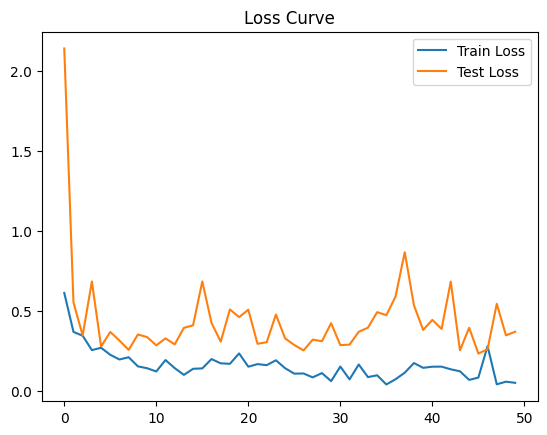

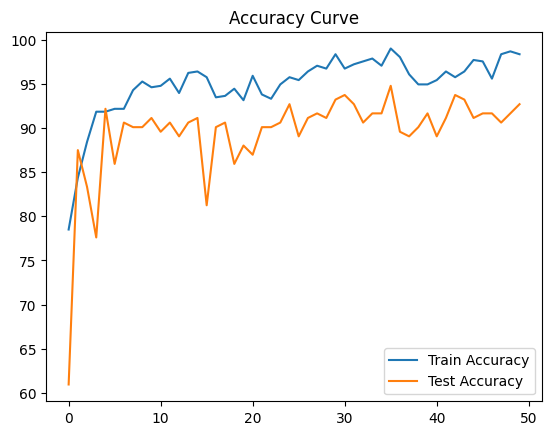

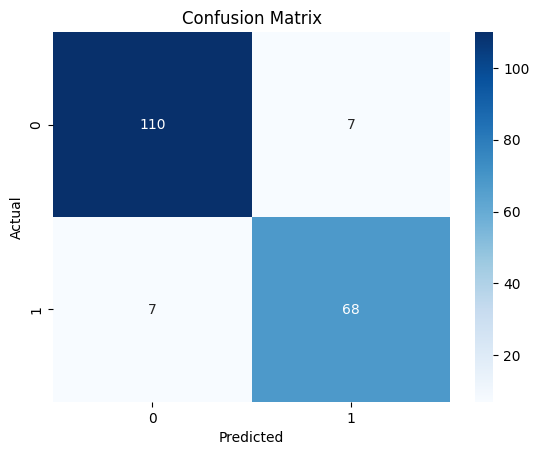

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       117
           1       0.91      0.91      0.91        75

    accuracy                           0.93       192
   macro avg       0.92      0.92      0.92       192
weighted avg       0.93      0.93      0.93       192



In [1]:
#heavily improvised 93pct saved with stats

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hybrid Model with Advanced Feature Fusion
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        
        self.cross_attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, batch_first=True)
        
        self.attention_weights = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        self.fc = nn.Linear(feature_dim, num_classes)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        attn_output, _ = self.cross_attention(fused_features.unsqueeze(1), fused_features.unsqueeze(1), fused_features.unsqueeze(1))
        attn_output = attn_output.squeeze(1)
        
        attention_scores = torch.sigmoid(self.attention_weights(attn_output))
        weighted_features = attn_output * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

# Training function
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)
        
        # Testing Phase
        model.eval()
        correct_test, total_test = 0, 0
        running_test_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                correct_test += (outputs.argmax(1) == labels).sum().item()
                total_test += labels.size(0)
                all_preds.extend(outputs.argmax(1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_accuracy = correct_test / total_test * 100
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Loss: {avg_test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")
        scheduler.step()
    
    torch.save(model.state_dict(), "hybrid_model.pth")
    
    plt.figure()
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.show()
    
    plt.figure()
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()
    
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(classification_report(all_labels, all_preds))

# Initialize and train model
model = HybridModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss()
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50] - Loss: 0.8787 - Train Acc: 77.36% - Test Loss: 0.6913 - Test Acc: 70.83%
Epoch [2/50] - Loss: 0.4039 - Train Acc: 83.71% - Test Loss: 0.3116 - Test Acc: 86.46%
Epoch [3/50] - Loss: 0.3205 - Train Acc: 86.16% - Test Loss: 0.2722 - Test Acc: 89.58%
Epoch [4/50] - Loss: 0.2755 - Train Acc: 89.58% - Test Loss: 0.3223 - Test Acc: 85.42%
Epoch [5/50] - Loss: 0.2383 - Train Acc: 90.88% - Test Loss: 0.3468 - Test Acc: 86.98%
Epoch [6/50] - Loss: 0.2814 - Train Acc: 87.62% - Test Loss: 0.3247 - Test Acc: 87.50%
Epoch [7/50] - Loss: 0.1586 - Train Acc: 93.32% - Test Loss: 0.2752 - Test Acc: 88.02%
Epoch [8/50] - Loss: 0.1765 - Train Acc: 91.86% - Test Loss: 0.3134 - Test Acc: 85.42%
Epoch [9/50] - Loss: 0.3076 - Train Acc: 91.04% - Test Loss: 0.3870 - Test Acc: 85.42%
Epoch [10/50] - Loss: 0.2230 - Train Acc: 91.86% - Test Loss: 0.3073 - Test Acc: 90.62%
Epoch [11/50] - Loss: 0.1510 - Train Acc: 93.16% - Test Loss: 0.2928 - Test Acc: 89.06%
Epoch [12/50] - Loss: 0.1629 - Train Acc:

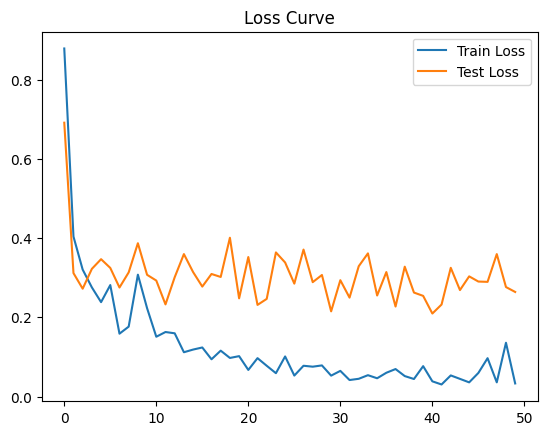

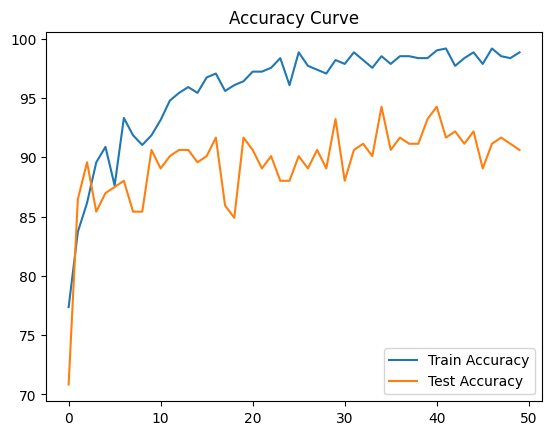

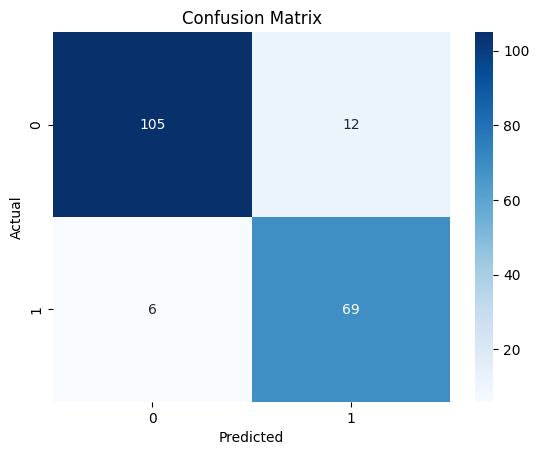

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       117
           1       0.85      0.92      0.88        75

    accuracy                           0.91       192
   macro avg       0.90      0.91      0.90       192
weighted avg       0.91      0.91      0.91       192



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hybrid Model with Advanced Feature Fusion
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        
        self.fc = nn.Linear(feature_dim, num_classes)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        weighted_features = self.batch_norm(fused_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

# Training function
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)
        
        # Testing Phase
        model.eval()
        correct_test, total_test = 0, 0
        running_test_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                correct_test += (outputs.argmax(1) == labels).sum().item()
                total_test += labels.size(0)
                all_preds.extend(outputs.argmax(1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_accuracy = correct_test / total_test * 100
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Loss: {avg_test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")
        scheduler.step(avg_test_loss)
    
    torch.save(model.state_dict(), "hybrid_modell.pth")
    
    # Visualization
    plt.figure()
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.show()
    
    plt.figure()
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()
    
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(classification_report(all_labels, all_preds))

# Initialize and train model
model = HybridModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss()
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# ✅ Define device (Use MPS if available, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Improved Hybrid Model
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features[:5].parameters():
            param.requires_grad = False  # Freeze early CNN layers
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        self.projection = nn.Linear(1280, 768)
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        for param in self.vit.encoder.layer[:6].parameters():
            param.requires_grad = False  # Freeze early ViT layers
        self.weight_cnn = nn.Parameter(torch.ones(1))
        self.weight_vit = nn.Parameter(torch.ones(1))
        self.softmax = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        cnn_features = self.projection(self.cnn(x).flatten(1))
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        weights = self.softmax(torch.cat([self.weight_cnn, self.weight_vit], dim=0))
        fused_features = weights[0] * cnn_features + weights[1] * vit_features
        fused_features = self.batch_norm(fused_features)
        fused_features = self.dropout(fused_features)
        return self.fc(fused_features)

# ✅ Load dataset
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing/"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ Initialize model
hybrid_model = HybridModel().to(device)

# ✅ Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=3e-5, weight_decay=5e-4)
scheduler_hybrid = get_cosine_schedule_with_warmup(optimizer_hybrid, num_warmup_steps=5, num_training_steps=50)

# ✅ Train function
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, scheduler, epochs=50):
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        avg_train_loss = running_train_loss / len(dataloader_train)
        train_accuracy = correct_train / total_train * 100
        
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloader_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)
        
        avg_val_loss = running_val_loss / len(dataloader_val)
        val_accuracy = correct_val / total_val * 100
        print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        scheduler.step()

# ✅ Train the model
train_model(hybrid_model, dataloader_train, dataloader_test, criterion, optimizer_hybrid, scheduler_hybrid, epochs=50)


Using device: mps


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [ ]:
# ✅ Define device (Use MPS if available, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# ✅ Paths to Dataset
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Testing"


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from torch.cuda.amp import autocast, GradScaler

# ✅ Define device (Use MPS if available, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# ✅ Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Reduce rotation range
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Lighter jitter
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Hybrid Model with ViT, CNN (EfficientNet), and Attention Mechanism
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features[:5].parameters():
            param.requires_grad = False  # Freeze early CNN layers
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        self.projection = nn.Linear(1280, 768)
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        for param in self.vit.encoder.layer[:6].parameters():
            param.requires_grad = False  # Freeze early ViT layers
        
        self.weight_cnn = nn.Parameter(torch.ones(1))
        self.weight_vit = nn.Parameter(torch.ones(1))
        self.softmax = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        cnn_features = self.projection(self.cnn(x).flatten(1))
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        weights = self.softmax(torch.cat([self.weight_cnn, self.weight_vit], dim=0))
        fused_features = weights[0] * cnn_features + weights[1] * vit_features
        fused_features = self.batch_norm(fused_features)
        fused_features = self.dropout(fused_features)
        return self.fc(fused_features)

# ✅ Load dataset with smaller batch size to optimize memory
batch_size = 16  # Reduce batch size to manage memory
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Testing"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ✅ Initialize model
hybrid_model = HybridModel().to(device)

# ✅ Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=3e-5, weight_decay=5e-4)
scheduler_hybrid = get_cosine_schedule_with_warmup(optimizer_hybrid, num_warmup_steps=5, num_training_steps=50)

# ✅ Mixed Precision Training Setup
scaler = GradScaler()

# ✅ Training Loop for Hybrid Model with Mixed Precision
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, scheduler, epochs=50):
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with autocast():  # Mixed precision context
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_train_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        avg_train_loss = running_train_loss / len(dataloader_train)
        train_accuracy = correct_train / total_train * 100
        
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloader_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)
        
        avg_val_loss = running_val_loss / len(dataloader_val)
        val_accuracy = correct_val / total_val * 100
        print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        scheduler.step()

# ✅ Train the Hybrid Model
train_model(hybrid_model, dataloader_train, dataloader_test, criterion, optimizer_hybrid, scheduler_hybrid, epochs=50)

# ✅ Generator and Discriminator for GANs
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1280 * 112 * 112)  # Reduced image size
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.fc1(z)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.tanh(x)
        return x.view(-1, 1280, 112, 112)  # Reduced image size

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 56 * 56, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return self.sigmoid(x)

# ✅ Training Loop for GAN
def train_gan(generator, discriminator, dataloader, num_epochs=50, z_dim=100, lr=0.0002):
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for real_images, _ in dataloader:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            
            # Train Discriminator
            optimizer_d.zero_grad()
            
            outputs_real = discriminator(real_images)
            loss_d_real = criterion(outputs_real, real_labels)
            
            z = torch.randn(batch_size, z_dim).to(device)
            fake_images = generator(z)
            outputs_fake = discriminator(fake_images.detach())
            loss_d_fake = criterion(outputs_fake, fake_labels)
            
            loss_d = loss_d_real + loss_d_fake
            loss_d.backward()
            optimizer_d.step()
            
            # Train Generator
            optimizer_g.zero_grad()
            outputs_fake = discriminator(fake_images)
            loss_g = criterion(outputs_fake, real_labels)
            loss_g.backward()
            optimizer_g.step()
            
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

# ✅ Initialize GANs and Train
generator = Generator(z_dim=100).to(device)
discriminator = Discriminator().to(device)

train_gan(generator, discriminator, dataloader_train)



/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/fold

Epoch [1/50] - Train Acc: 47.88%, Val Acc: 53.51%
Epoch [2/50] - Train Acc: 69.10%, Val Acc: 79.34%
Epoch [3/50] - Train Acc: 80.72%, Val Acc: 83.03%
Epoch [4/50] - Train Acc: 84.41%, Val Acc: 81.92%
Epoch [5/50] - Train Acc: 86.62%, Val Acc: 84.50%
Epoch [6/50] - Train Acc: 87.36%, Val Acc: 83.39%
Epoch [7/50] - Train Acc: 89.11%, Val Acc: 84.87%
Epoch [8/50] - Train Acc: 89.85%, Val Acc: 81.92%
Epoch [9/50] - Train Acc: 90.68%, Val Acc: 82.29%
Epoch [10/50] - Train Acc: 88.75%, Val Acc: 84.13%
Epoch [11/50] - Train Acc: 90.13%, Val Acc: 84.50%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from torch.cuda.amp import autocast, GradScaler

# ✅ Define device (Use MPS if available, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Reduced rotation range
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Lighter jitter
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Hybrid Model with ViT, CNN (EfficientNet), and Attention Mechanism
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features[:5].parameters():
            param.requires_grad = False  # Freeze early CNN layers
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        self.projection = nn.Linear(1280, 768)
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        for param in self.vit.encoder.layer[:6].parameters():
            param.requires_grad = False  # Freeze early ViT layers
        
        self.weight_cnn = nn.Parameter(torch.ones(1))
        self.weight_vit = nn.Parameter(torch.ones(1))
        self.softmax = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        cnn_features = self.projection(self.cnn(x).flatten(1))
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        weights = self.softmax(torch.cat([self.weight_cnn, self.weight_vit], dim=0))
        fused_features = weights[0] * cnn_features + weights[1] * vit_features
        fused_features = self.batch_norm(fused_features)
        fused_features = self.dropout(fused_features)
        return self.fc(fused_features)

# ✅ Load dataset with smaller batch size to optimize memory
batch_size = 32  # Reduce batch size to manage memory
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Testing"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ✅ Initialize model
hybrid_model = HybridModel().to(device)

# ✅ Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=3e-5, weight_decay=5e-4)
scheduler_hybrid = get_cosine_schedule_with_warmup(optimizer_hybrid, num_warmup_steps=5, num_training_steps=50)

# ✅ Mixed Precision Training Setup
scaler = GradScaler()

# ✅ Training Loop for Hybrid Model with Mixed Precision
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, scheduler, epochs=50):
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with autocast():  # Mixed precision context
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_train_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        avg_train_loss = running_train_loss / len(dataloader_train)
        train_accuracy = correct_train / total_train * 100
        
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloader_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)
        
        avg_val_loss = running_val_loss / len(dataloader_val)
        val_accuracy = correct_val / total_val * 100
        print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        scheduler.step()

# ✅ Train the Hybrid Model
train_model(hybrid_model, dataloader_train, dataloader_test, criterion, optimizer_hybrid, scheduler_hybrid, epochs=50)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/fold

Epoch [1/50] - Train Acc: 45.48%, Val Acc: 46.13%
Epoch [2/50] - Train Acc: 61.72%, Val Acc: 79.34%
Epoch [3/50] - Train Acc: 76.29%, Val Acc: 80.81%
Epoch [4/50] - Train Acc: 82.56%, Val Acc: 84.50%
Epoch [5/50] - Train Acc: 85.24%, Val Acc: 83.76%
Epoch [6/50] - Train Acc: 87.55%, Val Acc: 83.03%
Epoch [7/50] - Train Acc: 88.47%, Val Acc: 81.55%
Epoch [8/50] - Train Acc: 90.77%, Val Acc: 84.50%
Epoch [9/50] - Train Acc: 91.70%, Val Acc: 83.03%
Epoch [10/50] - Train Acc: 91.70%, Val Acc: 81.55%
Epoch [11/50] - Train Acc: 92.34%, Val Acc: 83.39%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import numpy as np

# ✅ Define device (Use MPS if available, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  # Increased rotation range
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Adjusted color jitter
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Multi-Head Attention Model
class HybridModelWithAttention(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2, num_heads=8, dropout=0.5):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features[:5].parameters():
            param.requires_grad = False  # Freeze early CNN layers
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        # Projection layer to match dimensions for attention
        self.projection = nn.Linear(1280, feature_dim)  
        
        # Multi-Head Attention Layer
        self.attn = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=num_heads, dropout=dropout)
        
        # Additional layers
        self.fc = nn.Linear(feature_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(feature_dim)

    def forward(self, x):
        # Extract features from CNN
        cnn_features = self.cnn(x).flatten(1)  # Flatten output of CNN
        
        # Projection to match the feature dimension of attention
        projected_features = self.projection(cnn_features).unsqueeze(0)  # Add batch dimension for MHA (1, batch_size, feature_dim)
        
        # Multi-Head Attention (Attention Layer)
        attn_output, attn_weights = self.attn(projected_features, projected_features, projected_features)  # Self-attention
        attn_output = attn_output.squeeze(0)  # Remove batch dimension
        
        # Batch normalization, dropout, and final classification
        attn_output = self.batch_norm(attn_output)
        attn_output = self.dropout(attn_output)
        
        return self.fc(attn_output)

# ✅ Load dataset
batch_size = 32  # Reduce batch size to manage memory
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Testing"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Initialize model
hybrid_model_with_attention = HybridModelWithAttention().to(device)

# ✅ Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()

# Add weight decay for regularization
optimizer_hybrid = optim.Adam(hybrid_model_with_attention.parameters(), lr=3e-5, weight_decay=1e-4)  # L2 regularization

# Cosine scheduler for learning rate decay
scheduler_hybrid = ReduceLROnPlateau(optimizer_hybrid, mode='max', patience=3, verbose=True)

# ✅ Train function with learning rate scheduler and early stopping
def train_model_with_regularization_and_lr_scheduler(model, dataloader_train, dataloader_val, criterion, optimizer, scheduler, epochs=50, patience=5):
    model = model.to(device)
    best_val_acc = 0.0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_train_loss / len(dataloader_train)
        train_accuracy = correct_train / total_train * 100

        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloader_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(dataloader_val)
        val_accuracy = correct_val / total_val * 100

        print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

        # Early stopping check
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping due to no improvement in validation accuracy")
                break  # Stop training if no improvement for `patience` epochs

        # Step the learning rate scheduler
        scheduler.step(val_accuracy)  # Use validation accuracy for scheduler

# ✅ Train with regularization and learning rate scheduler
train_model_with_regularization_and_lr_scheduler(hybrid_model_with_attention, dataloader_train, dataloader_test, criterion, optimizer_hybrid, scheduler_hybrid, epochs=50, patience=5)


Using device: mps


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50] - Train Acc: 68.91%, Val Acc: 75.28%
Epoch [2/50] - Train Acc: 76.29%, Val Acc: 78.60%
Epoch [3/50] - Train Acc: 79.34%, Val Acc: 80.81%
Epoch [4/50] - Train Acc: 79.34%, Val Acc: 80.07%
Epoch [5/50] - Train Acc: 80.90%, Val Acc: 80.44%
Epoch [6/50] - Train Acc: 81.09%, Val Acc: 80.07%
Epoch [7/50] - Train Acc: 82.29%, Val Acc: 81.18%
Epoch [8/50] - Train Acc: 83.30%, Val Acc: 83.39%
Epoch [9/50] - Train Acc: 82.84%, Val Acc: 83.76%
Epoch [10/50] - Train Acc: 83.30%, Val Acc: 84.87%
Epoch [11/50] - Train Acc: 84.78%, Val Acc: 80.44%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets

# ✅ Define device (Use MPS if available, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  # Increased rotation range
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Adjusted color jitter
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Improved Hybrid Model with Multihead Attention
class HybridModelWithMHA(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features[:5].parameters():
            param.requires_grad = False  # Freeze early CNN layers
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # Remove the final classifier
        
        # Projection to match feature size (if necessary)
        self.projection = nn.Linear(1280, feature_dim)
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.weight_cnn = nn.Parameter(torch.ones(1))
        self.weight_vit = nn.Parameter(torch.ones(1))
        self.softmax = nn.Softmax(dim=0)
        
        # Multihead Attention Layer
        self.multihead_attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, dropout=0.1)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
        
        # Update the fully connected layer size
        self.fc = nn.Linear(feature_dim, num_classes)
        
    def forward(self, x):
        # CNN features
        cnn_features = self.cnn(x).flatten(1)  # Flatten before passing to projection layer
        cnn_features = self.projection(cnn_features)  # Project to feature_dim
        
        # ViT features
        vit_features = self.vit(x).last_hidden_state[:, 0, :]  # Take the CLS token
        
        # Fusion of CNN and ViT features
        weights = self.softmax(torch.cat([self.weight_cnn, self.weight_vit], dim=0))
        fused_features = weights[0] * cnn_features + weights[1] * vit_features
        
        # Multihead Attention
        # Adding batch_size as first dimension for multihead attention
        attn_output, _ = self.multihead_attention(fused_features.unsqueeze(0), fused_features.unsqueeze(0), fused_features.unsqueeze(0))
        attn_output = attn_output.squeeze(0)  # Remove batch dimension
        
        # Batch normalization and dropout
        fused_features = self.batch_norm(attn_output)
        fused_features = self.dropout(fused_features)
        
        return self.fc(fused_features)

# ✅ Load dataset
batch_size = 32  # Reduce batch size to manage memory
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Testing"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Initialize model
model_with_mha_and_gan = HybridModelWithMHA().to(device)

# ✅ Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()

# Add weight decay for regularization
optimizer_hybrid = optim.Adam(model_with_mha_and_gan.parameters(), lr=3e-5, weight_decay=1e-4)  # L2 regularization

# Cosine scheduler for learning rate decay
scheduler_hybrid = ReduceLROnPlateau(optimizer_hybrid, mode='max', patience=3, verbose=True)

# ✅ Train function with learning rate scheduler and early stopping
def train_model_with_regularization_and_lr_scheduler(model, dataloader_train, dataloader_val, criterion, optimizer, scheduler, epochs=50, patience=5):
    model = model.to(device)
    best_val_acc = 0.0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_train_loss / len(dataloader_train)
        train_accuracy = correct_train / total_train * 100

        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloader_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(dataloader_val)
        val_accuracy = correct_val / total_val * 100

        print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

        # Early stopping check
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping due to no improvement in validation accuracy")
                break  # Stop training if no improvement for `patience` epochs

        # Step the learning rate scheduler
        scheduler.step(val_accuracy)  # Use validation accuracy for scheduler

# ✅ Train with regularization and learning rate scheduler
train_model_with_regularization_and_lr_scheduler(model_with_mha_and_gan, dataloader_train, dataloader_test, criterion, optimizer_hybrid, scheduler_hybrid, epochs=50, patience=5)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ra

Epoch [1/50] - Train Acc: 77.49%, Val Acc: 79.34%
Epoch [2/50] - Train Acc: 83.76%, Val Acc: 81.18%
Epoch [3/50] - Train Acc: 85.15%, Val Acc: 83.03%
Epoch [4/50] - Train Acc: 86.81%, Val Acc: 83.03%
Epoch [5/50] - Train Acc: 88.47%, Val Acc: 85.24%
Epoch [6/50] - Train Acc: 87.18%, Val Acc: 81.18%
Epoch [7/50] - Train Acc: 90.68%, Val Acc: 81.55%
Epoch [8/50] - Train Acc: 89.39%, Val Acc: 81.92%
Epoch [9/50] - Train Acc: 88.65%, Val Acc: 82.66%
Epoch [10/50] - Train Acc: 91.14%, Val Acc: 82.29%
Early stopping due to no improvement in validation accuracy


In [ ]:
print()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Set up device (MPS, CUDA, or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data Augmentation with MixUp, CutMix, RandAugment
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Testing"

# Dataset loading
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Components
class HybridModelWithMHA(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        
        # CNN Backbone (EfficientNet + Pretrained)
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features[:5].parameters():
            param.requires_grad = False
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        # Vision Transformer (ViT)
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        
        # Fusion Layer
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        # Multihead Attention for feature fusion
        self.multihead_attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, dropout=0.1)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # CNN features
        cnn_features = self.cnn(x).flatten(1)
        
        # ViT features (CLS token)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        
        # Feature Fusion (Concatenation and Projection)
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        # Multihead Attention
        attn_output, _ = self.multihead_attention(fused_features.unsqueeze(0), fused_features.unsqueeze(0), fused_features.unsqueeze(0))
        attn_output = attn_output.squeeze(0)
        
        # Batch normalization, dropout, and classifier
        fused_features = self.batch_norm(attn_output)
        fused_features = self.dropout(fused_features)
        return self.fc(fused_features)

# Optimizer and Learning Rate Scheduler
def get_optimizer_and_scheduler(model, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
    return optimizer, scheduler

# Loss Function
criterion = nn.CrossEntropyLoss()

# Evaluation Metrics
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion Matrix and AUC
    cm = confusion_matrix(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    test_accuracy = correct_test / total_test * 100
    print(f"Confusion Matrix:\n{cm}")
    print(f"AUC: {auc:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    return cm, auc, test_accuracy

# Training Loop with Checkpointing & Early Stopping
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50, patience=5):
    writer = SummaryWriter()
    best_val_acc = 0.0
    epochs_without_improvement = 0
    checkpoint_path = "best_model.pth"
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        # Training Phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}%")
        
        # Evaluation Phase
        cm, auc, test_accuracy = evaluate_model(model, test_loader, device)
        val_acc = auc  # Use AUC as evaluation metric
        
        # Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping due to no improvement")
                break
        
        # Learning Rate Scheduling
        scheduler.step()
        
        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/test', test_accuracy, epoch)
    
    # Load best model
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Best Model Loaded with AUC: {best_val_acc:.4f}")
    writer.close()

# Model Initialization
model = HybridModelWithMHA().to(device)

# Optimizer and Scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# Train the Model
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/50] - Loss: 0.5138 - Train Acc: 77.21%
Confusion Matrix:
[[103  10]
 [ 55 103]]
AUC: 0.7817
Test Accuracy: 76.01%
Epoch [2/50] - Loss: 0.3802 - Train Acc: 84.50%
Confusion Matrix:
[[ 85  28]
 [ 17 141]]
AUC: 0.8223
Test Accuracy: 83.39%
Epoch [3/50] - Loss: 0.3373 - Train Acc: 85.15%
Confusion Matrix:
[[ 71  42]
 [ 13 145]]
AUC: 0.7730
Test Accuracy: 79.70%
Epoch [4/50] - Loss: 0.3343 - Train Acc: 84.96%
Confusion Matrix:
[[ 93  20]
 [ 27 131]]
AUC: 0.8261
Test Accuracy: 82.66%
Epoch [5/50] - Loss: 0.2866 - Train Acc: 86.99%
Confusion Matrix:
[[ 73  40]
 [  8 150]]
AUC: 0.7977
Test Accuracy: 82.29%
Epoch [6/50] - Loss: 0.2870 - Train Acc: 88.84%
Confusion Matrix:
[[ 80  33]
 [ 15 143]]
AUC: 0.8065
Test Accuracy: 82.29%
Epoch [7/50] - Loss: 0.2694 - Train Acc: 87.73%
Confusion Matrix:
[[101  12]
 [ 31 127]]
AUC: 0.8488
Test Accuracy: 84.13%
Epoch [8/50] - Loss: 0.2300 - Train Acc: 89.39%
Confusion Matrix:
[[ 79  34]
 [ 12 146]]
AUC: 0.8116
Test Accuracy: 83.03%
Epoch [9/50] - L

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Set up device (MPS, CUDA, or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),  # Ensure ToTensor is the last transformation before any tensor-specific operations
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+origa/Testing"

# Dataset loading
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Components with more layers unfrozen in EfficientNet
class HybridModelWithMHA(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        
        # CNN Backbone (EfficientNet + Pretrained)
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features.parameters():
            param.requires_grad = True  # Unfreeze all layers
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        # Vision Transformer (ViT)
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        
        # Fusion Layer
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        # Multihead Attention for feature fusion
        self.multihead_attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, dropout=0.1)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # CNN features
        cnn_features = self.cnn(x).flatten(1)
        
        # ViT features (CLS token)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        
        # Feature Fusion (Concatenation and Projection)
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        # Multihead Attention
        attn_output, _ = self.multihead_attention(fused_features.unsqueeze(0), fused_features.unsqueeze(0), fused_features.unsqueeze(0))
        attn_output = attn_output.squeeze(0)
        
        # Batch normalization, dropout, and classifier
        fused_features = self.batch_norm(attn_output)
        fused_features = self.dropout(fused_features)
        return self.fc(fused_features)

# Optimizer and Learning Rate Scheduler with Warmup
def get_optimizer_and_scheduler(model, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
    return optimizer, scheduler

# Loss Function
criterion = nn.CrossEntropyLoss()

# Evaluation Metrics
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion Matrix, AUC, Precision-Recall and F1-score
    cm = confusion_matrix(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    test_accuracy = correct_test / total_test * 100
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"AUC: {auc:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f} - Recall: {recall:.4f} - F1-score: {f1:.4f}")
    
    return cm, auc, test_accuracy, precision, recall, f1

# Training Loop with Checkpointing & Early Stopping
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50, patience=5):
    writer = SummaryWriter()
    best_val_acc = 0.0
    epochs_without_improvement = 0
    checkpoint_path = "best_model.pth"
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        # Training Phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}%")
        
        # Evaluation Phase
        cm, auc, test_accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)
        val_acc = auc  # Use AUC as evaluation metric
        
        # Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping due to no improvement")
                break
        
        # Learning Rate Scheduling
        scheduler.step()
        
        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/test', test_accuracy, epoch)
        writer.add_scalar('Precision/test', precision, epoch)
        writer.add_scalar('Recall/test', recall, epoch)
        writer.add_scalar('F1/test', f1, epoch)
    
    # Load best model
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Best Model Loaded with AUC: {best_val_acc:.4f}")
    writer.close()

# Model Initialization
model = HybridModelWithMHA().to(device)

# Optimizer and Scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# Train the Model
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


Using device: mps


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/50] - Loss: 0.5244 - Train Acc: 75.28%
Confusion Matrix:
[[ 65  48]
 [ 11 147]]
AUC: 0.7528
Test Accuracy: 78.23%
Precision: 0.7538 - Recall: 0.9304 - F1-score: 0.8329
Epoch [2/50] - Loss: 0.4082 - Train Acc: 82.10%
Confusion Matrix:
[[ 81  32]
 [ 14 144]]
AUC: 0.8141
Test Accuracy: 83.03%
Precision: 0.8182 - Recall: 0.9114 - F1-score: 0.8623
Epoch [3/50] - Loss: 0.3243 - Train Acc: 86.16%
Confusion Matrix:
[[ 93  20]
 [ 28 130]]
AUC: 0.8229
Test Accuracy: 82.29%
Precision: 0.8667 - Recall: 0.8228 - F1-score: 0.8442
Epoch [4/50] - Loss: 0.2958 - Train Acc: 87.27%
Confusion Matrix:
[[ 79  34]
 [  7 151]]
AUC: 0.8274
Test Accuracy: 84.87%
Precision: 0.8162 - Recall: 0.9557 - F1-score: 0.8805
Epoch [5/50] - Loss: 0.2802 - Train Acc: 87.45%
Confusion Matrix:
[[ 85  28]
 [ 27 131]]
AUC: 0.7907
Test Accuracy: 79.70%
Precision: 0.8239 - Recall: 0.8291 - F1-score: 0.8265
Epoch [6/50] - Loss: 0.2718 - Train Acc: 88.10%
Confusion Matrix:
[[105   8]
 [ 39 119]]
AUC: 0.8412
Test Accuracy:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import WeightedRandomSampler

# Set up device (MPS, CUDA, or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data augmentation pipeline with stronger regularization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),  # Ensure ToTensor is the last transformation before any tensor-specific operations
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/DRISHTI-GS/DRISHTI-GS/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/DRISHTI-GS/DRISHTI-GS/Testing"

# Dataset loading with class weights to handle class imbalance
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Calculate class weights
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts[label] += 1
class_weights = [sum(class_counts) / count for count in class_counts]
class_weights = torch.tensor(class_weights).to(device)

# WeightedRandomSampler to handle class imbalance
weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Components with more layers unfrozen in EfficientNet
class HybridModelWithMHA(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        
        # CNN Backbone (EfficientNet + Pretrained)
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features.parameters():
            param.requires_grad = True  # Unfreeze all layers
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        # Vision Transformer (ViT)
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        
        # Fusion Layer
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        # Multihead Attention for feature fusion
        self.multihead_attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, dropout=0.2)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.6)  # Increased dropout for more regularization

    def forward(self, x):
        # CNN features
        cnn_features = self.cnn(x).flatten(1)
        
        # ViT features (CLS token)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        
        # Feature Fusion (Concatenation and Projection)
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        # Multihead Attention
        attn_output, _ = self.multihead_attention(fused_features.unsqueeze(0), fused_features.unsqueeze(0), fused_features.unsqueeze(0))
        attn_output = attn_output.squeeze(0)
        
        # Batch normalization, dropout, and classifier
        fused_features = self.batch_norm(attn_output)
        fused_features = self.dropout(fused_features)
        return self.fc(fused_features)

# Optimizer and Learning Rate Scheduler with Warmup
def get_optimizer_and_scheduler(model, lr=1e-5):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization (weight decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
    return optimizer, scheduler

# Loss Function with Class Weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Evaluation Metrics
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion Matrix, AUC, Precision-Recall and F1-score
    cm = confusion_matrix(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    test_accuracy = correct_test / total_test * 100
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"AUC: {auc:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f} - Recall: {recall:.4f} - F1-score: {f1:.4f}")
    
    return cm, auc, test_accuracy, precision, recall, f1

# Training Loop without Early Stopping
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    writer = SummaryWriter()
    best_val_acc = 0.0
    checkpoint_path = "best_model.pth"
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        # Training Phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}%")
        
        # Evaluation Phase
        cm, auc, test_accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)
        val_acc = auc  # Use AUC as evaluation metric
        
        # Save best model based on AUC
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path)
        
        # Learning Rate Scheduling
        scheduler.step()
        
        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/test', test_accuracy, epoch)
        writer.add_scalar('Precision/test', precision, epoch)
        writer.add_scalar('Recall/test', recall, epoch)
        writer.add_scalar('F1/test', f1, epoch)
    
    # Load best model
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Best Model Loaded with AUC: {best_val_acc:.4f}")
    writer.close()

# Model Initialization
model = HybridModelWithMHA().to(device)

# Optimizer and Scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# Train the Model
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

# Set up device (MPS, CUDA, or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data augmentation pipeline with stronger regularization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/ACRIMA/ACRIMA/PARTITIONED/Training/"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/ACRIMA/ACRIMA/PARTITIONED/Testing/"

# Dataset loading with class weights to handle class imbalance
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Calculate class weights
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts[label] += 1
class_weights = [sum(class_counts) / count for count in class_counts]
class_weights = torch.tensor(class_weights).to(device)

# WeightedRandomSampler to handle class imbalance
weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Components with more layers unfrozen in EfficientNet
class HybridModelWithMHA(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        
        # CNN Backbone (EfficientNet + Pretrained)
        self.cnn = models.efficientnet_b0(pretrained=True)
        for param in self.cnn.features.parameters():
            param.requires_grad = True  # Unfreeze all layers
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        # Vision Transformer (ViT)
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        
        # Fusion Layer
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)
        
        # Multihead Attention for feature fusion
        self.multihead_attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, dropout=0.2)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)  # Moderate dropout for regularization

    def forward(self, x):
        # CNN features
        cnn_features = self.cnn(x).flatten(1)
        
        # ViT features (CLS token)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        
        # Feature Fusion (Concatenation and Projection)
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        # Multihead Attention
        attn_output, _ = self.multihead_attention(fused_features.unsqueeze(0), fused_features.unsqueeze(0), fused_features.unsqueeze(0))
        attn_output = attn_output.squeeze(0)
        
        # Batch normalization, dropout, and classifier
        fused_features = self.batch_norm(attn_output)
        fused_features = self.dropout(fused_features)
        return self.fc(fused_features)

# Optimizer and Learning Rate Scheduler with Warmup
def get_optimizer_and_scheduler(model, lr=1e-5, warmup_steps=5):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Learning Rate Warmup Function
    def lr_lambda(current_step: int):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        return 1.0
    
    scheduler = LambdaLR(optimizer, lr_lambda)
    return optimizer, scheduler

# Mixup Augmentation Function
def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index]
    return mixed_x, mixed_y

# Loss Function with Class Weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Evaluation Metrics
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion Matrix, AUC, Precision-Recall and F1-score
    cm = confusion_matrix(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    test_accuracy = correct_test / total_test * 100
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"AUC: {auc:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f} - Recall: {recall:.4f} - F1-score: {f1:.4f}")
    
    return cm, auc, test_accuracy, precision, recall, f1

# Training Loop without Early Stopping
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    writer = SummaryWriter()
    best_val_acc = 0.0
    checkpoint_path = "best_model.pth"
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        # Training Phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Mixup data
            inputs, labels = mixup_data(inputs, labels)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}%")
        
        # Evaluation Phase
        cm, auc, test_accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)
        val_acc = auc  # Use AUC as evaluation metric
        
        # Save best model based on AUC
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path)
        
        # Learning Rate Scheduling
        scheduler.step()
        
        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/test', test_accuracy, epoch)
        writer.add_scalar('Precision/test', precision, epoch)
        writer.add_scalar('Recall/test', recall, epoch)
        writer.add_scalar('F1/test', f1, epoch)
    
    # Load best model
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Best Model Loaded with AUC: {best_val_acc:.4f}")
    writer.close()

# Model Initialization
model = HybridModelWithMHA().to(device)

# Optimizer and Scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# Train the Model
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/50] - Loss: 0.8948 - Train Acc: 25.18%
Confusion Matrix:
[[11 68]
 [10 52]]
AUC: 0.4890
Test Accuracy: 44.68%
Precision: 0.4333 - Recall: 0.8387 - F1-score: 0.5714
Epoch [2/50] - Loss: 0.8837 - Train Acc: 23.58%
Confusion Matrix:
[[24 55]
 [ 9 53]]
AUC: 0.5793
Test Accuracy: 54.61%
Precision: 0.4907 - Recall: 0.8548 - F1-score: 0.6235
Epoch [3/50] - Loss: 0.7992 - Train Acc: 29.26%
Confusion Matrix:
[[51 28]
 [ 9 53]]
AUC: 0.7502
Test Accuracy: 73.76%
Precision: 0.6543 - Recall: 0.8548 - F1-score: 0.7413
Epoch [4/50] - Loss: 0.7406 - Train Acc: 35.28%
Confusion Matrix:
[[50 29]
 [ 7 55]]
AUC: 0.7600
Test Accuracy: 74.47%
Precision: 0.6548 - Recall: 0.8871 - F1-score: 0.7534
Epoch [5/50] - Loss: 0.6648 - Train Acc: 38.65%
Confusion Matrix:
[[56 23]
 [ 3 59]]
AUC: 0.8302
Test Accuracy: 81.56%
Precision: 0.7195 - Recall: 0.9516 - F1-score: 0.8194
Epoch [6/50] - Loss: 0.7115 - Train Acc: 35.82%
Confusion Matrix:
[[75  4]
 [10 52]]
AUC: 0.8940
Test Accuracy: 90.07%
Precision: 0.928

KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

# Set up device (MPS, CUDA, or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data augmentation pipeline with regularization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/DRISHTI-GS/DRISHTI-GS/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/DRISHTI-GS/DRISHTI-GS/Testing"

# Dataset loading with class weights to handle class imbalance
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Calculate class weights
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts[label] += 1
class_weights = [sum(class_counts) / count for count in class_counts]
class_weights = torch.tensor(class_weights).to(device)

# WeightedRandomSampler to handle class imbalance
weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Simplified Model
class SimpleModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        
        # Use ResNet18 instead of EfficientNet and ViT for simpler model
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, num_classes)  # Replace final layer

    def forward(self, x):
        return self.cnn(x)

# Optimizer and Learning Rate Scheduler with Warmup
def get_optimizer_and_scheduler(model, lr=1e-4, warmup_steps=5):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Learning Rate Warmup Function
    def lr_lambda(current_step: int):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        return 1.0
    
    scheduler = LambdaLR(optimizer, lr_lambda)
    return optimizer, scheduler

# Loss Function with Class Weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Evaluation Metrics
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion Matrix, AUC, Precision-Recall and F1-score
    cm = confusion_matrix(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    test_accuracy = correct_test / total_test * 100
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"AUC: {auc:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f} - Recall: {recall:.4f} - F1-score: {f1:.4f}")
    
    return cm, auc, test_accuracy, precision, recall, f1

# Training Loop without Early Stopping
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    writer = SummaryWriter()
    best_val_acc = 0.0
    checkpoint_path = "best_model.pth"
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        # Training Phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}%")
        
        # Evaluation Phase
        cm, auc, test_accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)
        val_acc = test_accuracy  # Use accuracy as evaluation metric for now
        
        # Save best model based on test accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path)
        
        # Learning Rate Scheduling
        scheduler.step()
        
        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/test', test_accuracy, epoch)
        writer.add_scalar('Precision/test', precision, epoch)
        writer.add_scalar('Recall/test', recall, epoch)
        writer.add_scalar('F1/test', f1, epoch)
    
    # Load best model
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Best Model Loaded with Accuracy: {best_val_acc:.2f}")
    writer.close()

# Model Initialization
model = SimpleModel().to(device)

# Optimizer and Scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# Train the Model
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50] - Loss: 0.9310 - Train Acc: 48.00%
Confusion Matrix:
[[ 3 35]
 [ 2 11]]
AUC: 0.4626
Test Accuracy: 27.45%
Precision: 0.2391 - Recall: 0.8462 - F1-score: 0.3729
Epoch [2/50] - Loss: 0.8815 - Train Acc: 40.00%
Confusion Matrix:
[[ 2 36]
 [ 2 11]]
AUC: 0.4494
Test Accuracy: 25.49%
Precision: 0.2340 - Recall: 0.8462 - F1-score: 0.3667
Epoch [3/50] - Loss: 0.7077 - Train Acc: 56.00%
Confusion Matrix:
[[ 3 35]
 [ 1 12]]
AUC: 0.5010
Test Accuracy: 29.41%
Precision: 0.2553 - Recall: 0.9231 - F1-score: 0.4000
Epoch [4/50] - Loss: 0.4649 - Train Acc: 90.00%
Confusion Matrix:
[[ 7 31]
 [ 1 12]]
AUC: 0.5536
Test Accuracy: 37.25%
Precision: 0.2791 - Recall: 0.9231 - F1-score: 0.4286
Epoch [5/50] - Loss: 0.1899 - Train Acc: 94.00%
Confusion Matrix:
[[15 23]
 [ 1 12]]
AUC: 0.6589
Test Accuracy: 52.94%
Precision: 0.3429 - Recall: 0.9231 - F1-score: 0.5000
Epoch [6/50] - Loss: 0.1317 - Train Acc: 100.00%
Confusion Matrix:
[[23 15]
 [ 4  9]]
AUC: 0.6488
Test Accuracy: 62.75%
Precision: 0.37

KeyboardInterrupt: 